# Analyzing the Twitter to XCorp Timeline and the Effect on the RePEc Database

This notebook aims to define and analyze the effect of Elon Musk's Twitter takeover and conversion to XCorp.

**Author: Eric Uehling**  
*Date: 3.7.24*

## Loading the Data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('../data/csv/cleaned_RePEc_tweets.csv', dtype={'referenced_id': str, 'id': str, 'author_id': str})

# Display the first few rows of the dataframe
df.head()

C:\Users\Eric\AppData\Local\Temp\ipykernel_7928\683770598.py:6: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/csv/cleaned_RePEc_tweets.csv', dtype={'referenced_id': str, 'id': str, 'author_id': str})


,RePEc_id,author_id,id,text,created_at,retweet_count,reply_count,like_count,quote_count,impression_count,referenced_id,referenced_type,lang
0,pal276,766166816922173440,1636234884212506625,Climate Spiral (1880-2022) – Climate Change #C...,2023-03-16 05:16:10+00:00,0,0,0,0,18.0,NaN,own,fr
1,pal276,766166816922173440,1635542184387842048,"""Assessment of the Shari’ah Requirements in th...",2023-03-14 07:23:38+00:00,0,0,1,0,14.0,NaN,own,en
2,pal276,766166816922173440,1635539997033119744,"""Implementation of Corporate Governance Princi...",2023-03-14 07:14:56+00:00,0,0,0,0,14.0,NaN,own,en
3,pal276,766166816922173440,1635536943521095680,"""The Dynamic Link Between Islamic and Conventi...",2023-03-14 07:02:48+00:00,0,0,0,0,21.0,NaN,own,en
4,pal276,766166816922173440,1635534446593200129,"""World Energy Economics and Geopolitics amid C...",2023-03-14 06:52:53+00:00,0,0,0,0,11.0,NaN,own,en


## Time Series Analysis of Tweets

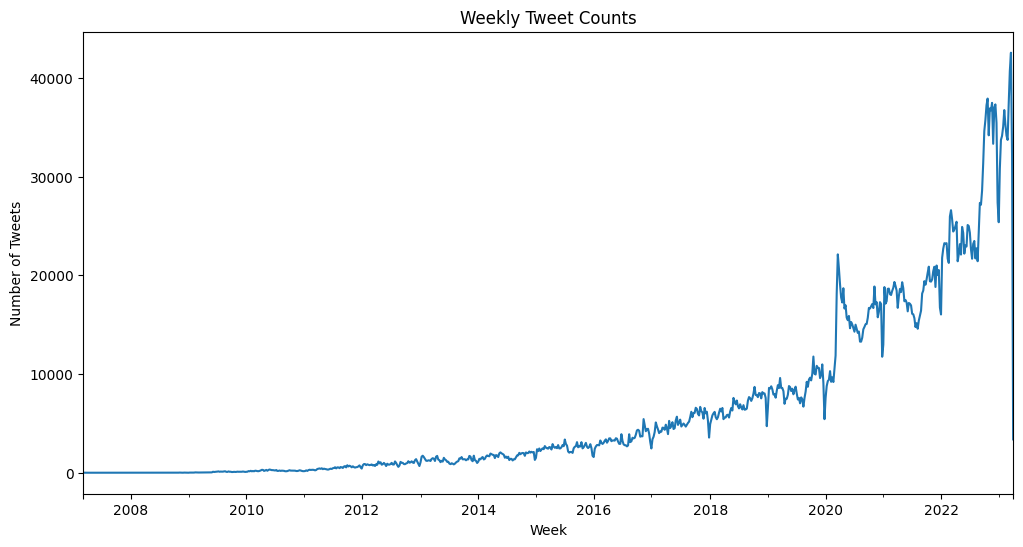

In [6]:
# Convert 'created_at' to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])

# Resampling to a weekly basis and counting tweets
weekly_tweets = df.resample('W', on='created_at').size()

# Plotting the time series of tweet counts
plt.figure(figsize=(12, 6))
weekly_tweets.plot(title='Weekly Tweet Counts')
plt.xlabel('Week')
plt.ylabel('Number of Tweets')
plt.show()

## Time Series Analysis of Tweets with Event Overlay

In addition to understanding general tweeting behavior over time, it's insightful to overlay significant external events that could influence this behavior. We have a timeline of events from Twitter and XCorp which we will overlay on our weekly tweet counts to observe any corresponding changes in tweet activity.

### Loading and Preprocessing the Twitter and XCorp Timeline Data

In [7]:
# Load the timeline data
timeline_df = pd.read_csv('../data/csv/Twitter_XCorp_Timeline.csv')
timeline_df['start_date'] = pd.to_datetime(timeline_df['start_date'])
timeline_df

,start_date,description,short_description
0,2022-01-31,Musk begins investing in Twitter.,Initial Investing From Musk
1,2022-03-14,"Musk's stake in Twitter reaches 9.2%, becoming...",9.2% Stake in Twitter
2,2022-04-04,Musk discloses his stake in Twitter; shares ri...,27% Stake in Twitter
3,2022-04-14,Musk offers to buy Twitter at $54.20 per share...,Initial Offer
4,2022-06-06,Musk threatens to pull out of the deal over bo...,Twitter Lawsuit Filed
5,2022-07-08,Musk moves to terminate the acquisition. Twitt...,Musk Pulls Out of Deal
6,2022-08-23,Whistleblower allegations of security lapses a...,Twitter Security Whistleblower
7,2022-10-04,Musk proposes to complete the acquisition. Mus...,Musk Closes Deal
8,2022-11-04,Musk lays off about half of Twitter's workforc...,Huge Layoffs
9,2022-12-04,"Launches new Twitter Blue, and faces impersona...",Twitter Blue Impersonation


### Overlaying Timeline Events on Weekly Tweet Counts

To visualize the potential impact of events on tweeting behavior, we will add vertical lines or markers to our weekly tweet count graph at the times when events occurred. This will allow us to see if there's a noticeable change in tweet activity around the time of each event.

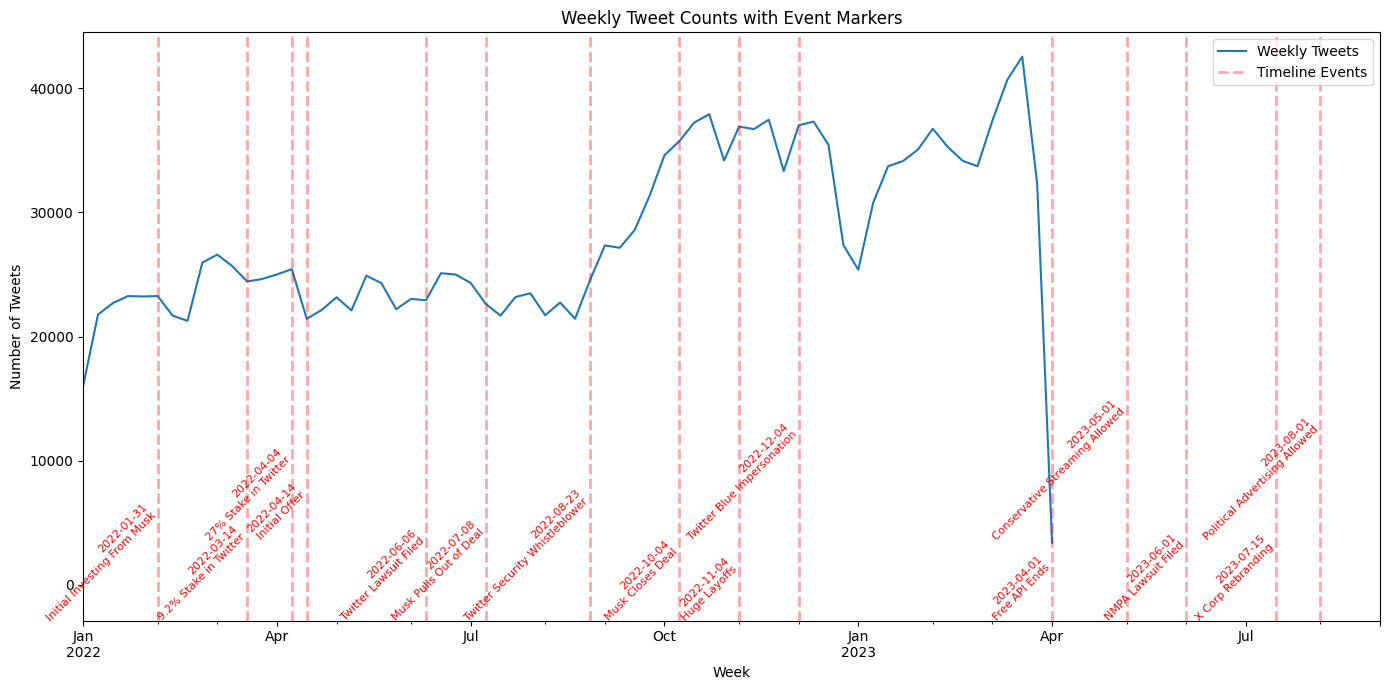

In [8]:
# Filter the tweet counts to include only data from 2020 onwards
start_date = '2022-01-01'
weekly_tweets_filtered = weekly_tweets[weekly_tweets.index >= start_date]

# Convert index of 'weekly_tweets_filtered' to tz-naive
weekly_tweets_filtered.index = weekly_tweets_filtered.index.tz_localize(None) # type: ignore

# Convert 'start_date' in 'timeline_df' to tz-naive
timeline_df['start_date'] = pd.to_datetime(timeline_df['start_date']).dt.tz_localize(None)

plt.figure(figsize=(14, 7))
weekly_tweets_filtered.plot(title='Weekly Tweet Counts with Event Markers')
plt.xlabel('Week')
plt.ylabel('Number of Tweets')

# Determine the latest date in your dataset or timeline events
latest_data_date = weekly_tweets_filtered.index.max()
latest_timeline_date = max(timeline_df['start_date'])
x_limit = max(latest_data_date, latest_timeline_date) + pd.Timedelta(days=30)  # Extend 30 days after the last event

# Setting x-axis limits to include all events
plt.xlim(weekly_tweets_filtered.index.min(), x_limit)

# Initial height for placing the text below the graph
y_pos_below = plt.ylim()[0] - (plt.ylim()[1] - plt.ylim()[0]) * 0.1

# Store the last position to compare with
last_position = None

# Overlaying the timeline events and adding text for each event below the graph
for _, row in timeline_df.iterrows():
    event_date = pd.to_datetime(row['start_date'])
    short_description = row['short_description']
    plt.axvline(x=event_date, color='red', linestyle='--', lw=2, alpha=0.35)
    
    # Dynamically adjust y_pos_below based on the proximity to the last event
    if last_position is not None and (event_date - last_position).days < 31:  # Example threshold: 30 days
        y_pos_now = y_pos_below + (plt.ylim()[1] - plt.ylim()[0]) * 0.15  # Adjust this value as needed
    else:
        y_pos_now = y_pos_below
    
    plt.text(event_date, y_pos_now, f"{event_date.strftime('%Y-%m-%d')}\n{short_description}",
             rotation=45, ha='right', fontsize=8, color='red')
    
    # Update last_position with the current event_date
    last_position = event_date

# Adjust y-axis limits to make space for text annotations dynamically
plt.ylim(min(y_pos_below, plt.ylim()[0]), plt.ylim()[1])

plt.legend(['Weekly Tweets', 'Timeline Events'])

plt.tight_layout()
plt.show()


### Overlaying Timeline Events on Weekly Tweet Counts by Referenced Type

Now we can look at this descrepancies based on `referenced_type`.

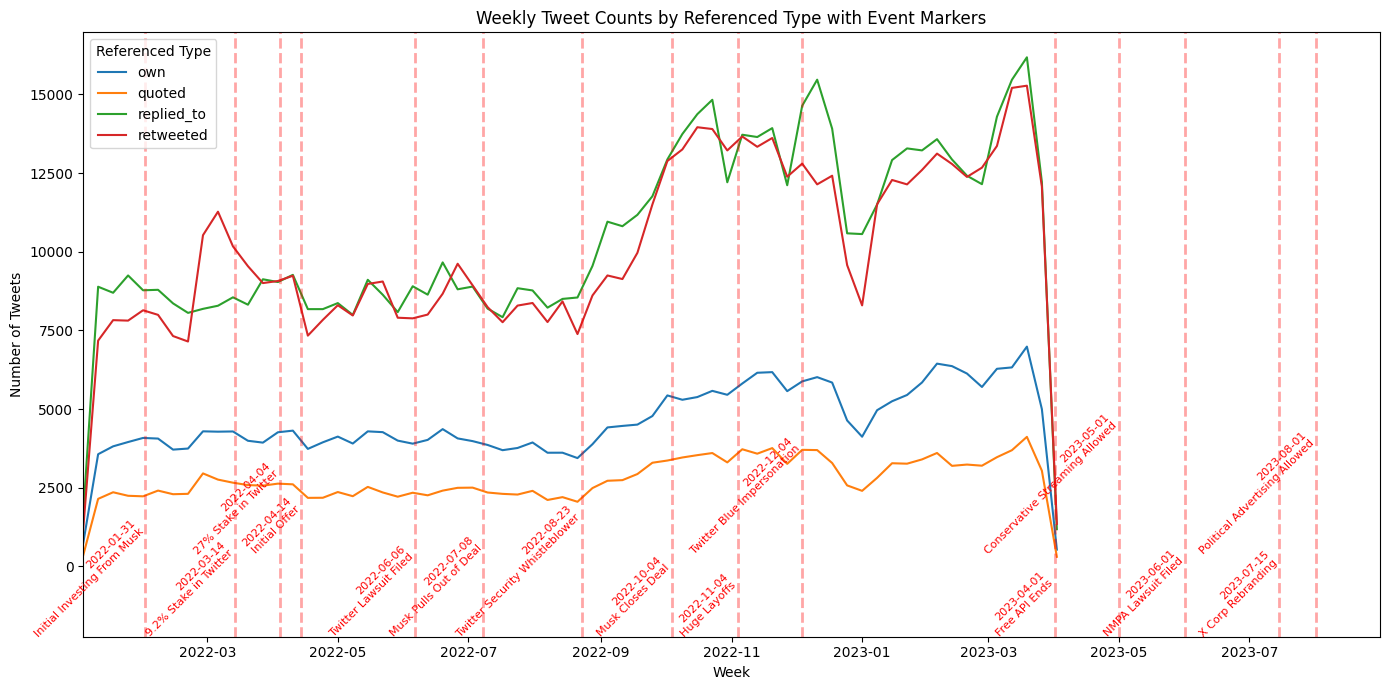

In [9]:
# Convert 'created_at' to tz-naive and filter the DataFrame
df['created_at'] = pd.to_datetime(df['created_at']).dt.tz_localize(None)
filtered_df = df[df['created_at'] >= '2022-01-01']

# Group by 'referenced_type', resample to a weekly basis, and count tweets
grouped_weekly_tweets = filtered_df.groupby('referenced_type').resample('W', on='created_at').size().unstack(0, fill_value=0)

# Plotting the time series of tweet counts for each 'referenced_type'
plt.figure(figsize=(14, 7))
for referenced_type in grouped_weekly_tweets.columns:
    plt.plot(grouped_weekly_tweets.index, grouped_weekly_tweets[referenced_type], label=referenced_type)

plt.title('Weekly Tweet Counts by Referenced Type with Event Markers')
plt.xlabel('Week')
plt.ylabel('Number of Tweets')

# Determine the latest date in the dataset or timeline events for x-axis limits
latest_data_date = grouped_weekly_tweets.index.max()
latest_timeline_date = max(timeline_df['start_date'])
x_limit = max(latest_data_date, latest_timeline_date) + pd.Timedelta(days=30)  # Extend 30 days after the last event

plt.xlim(grouped_weekly_tweets.index.min(), x_limit)

# Initial height for placing the text below the graph
y_pos_below_initial = plt.ylim()[0] - (plt.ylim()[1] - plt.ylim()[0]) * 0.1

# Store the last position to compare with
last_position = None

# Overlaying the timeline events and adding text for each event below the graph
for _, row in timeline_df.iterrows():
    event_date = pd.to_datetime(row['start_date'])
    short_description = row['short_description']
    plt.axvline(x=event_date, color='red', linestyle='--', lw=2, alpha=0.35)  # Set alpha for opacity
    
    # Dynamically adjust y_pos_below based on the proximity to the last event
    if last_position is not None and (event_date - last_position).days < 31:  # Example threshold: 30 days
        y_pos_now = y_pos_below_initial + (plt.ylim()[1] - plt.ylim()[0]) * 0.15  # Adjust this value as needed
    else:
        y_pos_now = y_pos_below_initial
    
    plt.text(event_date, y_pos_now, f"{event_date.strftime('%Y-%m-%d')}\n{short_description}",
             rotation=45, ha='right', fontsize=8, color='red')
    
    # Update last_position with the current event_date
    last_position = event_date

# Adjust y-axis limits to make space for text annotations dynamically
plt.ylim(min(y_pos_below_initial, plt.ylim()[0]), plt.ylim()[1])

plt.legend(title='Referenced Type')
plt.tight_layout()
plt.show()
